---
## **Projet Machine Learning Avancé : Master 2 ISI**
---
**Membres du Groupe** :
- *Tarek BENAISSA*                     
- *M'hamed BENABID*                     
- *Zahra Hafida BENSLIMANE*            
- *Mohammed El Amine BENBRAHIM*


**Installation and import of the necessary modules and libraries.**

<div class="alert alert-block alert-info">
<b>NOTE : </b> This next cell should can be ignored if you already have <b>tensorflow-text</b> module installed in your environement.
</div>

In [316]:
#pip install tensorflow-text

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [317]:
# Import des librairies
import numpy as np
import typing
import pandas as pd
from typing import Any, Tuple
import tensorflow as tf
import tensorflow_text as tf_text
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from utils import load_data, tf_lower_and_split_punct


In [3]:
# Cette variable est utilisée pour basculer entre les implémentations personnalisées ( qu'on crée à partir de zéro) et intégrées.
use_builtins = True

In [4]:
import os
#os.listdir()
from zipfile import ZipFile 
with ZipFile ('mini_base_donnees_3.txt.zip', 'r') as zipObj : 
    #Extraire tt les fichiers dans le directory : 
    zipObj.extractall()


In [5]:
#os.listdir()

**Downloading our training dataset**

In [6]:
# Téchargement de la base d'apprentissage
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'fra-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'fra.txt'
#path_to_file = pathlib.Path('mini_base_donnees_3.txt')

In [7]:
targ, inp = load_data(path_to_file)

# Taille des données d'entrée
print("Nombre de phrases contenus dans les données : ", len(inp))
# pour montrer qu'on a des longueurs différentes
taille_input = [len(p) for p in inp]
print("Nombre de mots de la plus petite phrase : ", min(taille_input))
print("Nombre de mots de la plus longue phrase : ", max(taille_input))

Lang_pairs = {'Source':inp,'Target':targ}
df = pd.DataFrame(Lang_pairs)
pd.set_option('max_colwidth', 800)
df.head()

Nombre de phrases contenus dans les données :  167130
Nombre de mots de la plus petite phrase :  4
Nombre de mots de la plus longue phrase :  349


,Source,Target
0,Va !,Go.
1,Salut !,Hi.
2,Cours !,Run!
3,Courez !,Run!
4,Qui ?,Who?


### **Dataset Preparation :**

In [8]:
BUFFER_SIZE = len(inp)
print(BUFFER_SIZE)
BATCH_SIZE = 64
print("Si on prend toutes les données on aura",round(BUFFER_SIZE/BATCH_SIZE), "exemples pour chaque epoque")

167130
Si on prend toutes les données on aura 2611 exemples pour chaque epoque


In [9]:
# on mélange les données pour ne pas avoir que des phrases de même longueur
# pour un entrainement plus léger on peut limiter les données en entrée à (inp[:50000], targ[:50000]) 
dataset = tf.data.Dataset.from_tensor_slices((inp[:128], targ[:128])).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

2022-12-09 14:17:31.058223: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-09 14:17:31.058318: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-12-09 14:17:31.059189: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
max_vocab_size = 5000

# We use TextVectorization to map text features to integer sequences
input_text_processor = tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct, max_tokens=max_vocab_size)
output_text_processor= tf.keras.layers.TextVectorization(standardize=tf_lower_and_split_punct,max_tokens=max_vocab_size)

input_text_processor.adapt(inp)
output_text_processor.adapt(targ)

out = output_text_processor.get_vocabulary()[:10]
inpt = input_text_processor.get_vocabulary()[:10]

print(f"Source Vocabulary size :{input_text_processor.vocabulary_size()} words")
print(f"Target Vocabulary size :{output_text_processor.vocabulary_size()} words ")
print("-"*35)

print(f"Source Vocab samples : {inpt}\nTarget Vocab samples : {out}")

Source Vocabulary size :5000 words
Target Vocabulary size :5000 words 
-----------------------------------
Source Vocab samples : ['', '[UNK]', '[START]', '[END]', '.', 'je', 'de', 'a', '?', 'pas']
Target Vocab samples : ['', '[UNK]', '[START]', '[END]', '.', 'i', 'you', 'to', 'the', '?']


### **Model Architechture Definition :**

#### **Encoder** 

1.
2.
3.


In [11]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        
        """
            inputs
            ------
                input_vocab_size : Tokenized input sequence
                embedding_dim    : 
                enc_units        :
        
        """
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # La couche d'embedding convertis les tokens vers des vecteurs 
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,embedding_dim)

        # Definition d'une couche GRU Bi-directionelle.
        self.bigru=tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.enc_units,
                                                                     return_sequences=True,
                                                                     return_state=True, 
                                                                     recurrent_initializer='glorot_uniform'))


    def call(self, tokens, state=None):
        
        """
            inputs
            ------
                tokens : Tokenized input sequence
                state  : 

            outputs
            -------
                output    : 
                finale_state_backward :          |Used To initialize the first hidden state of the decoder??
                
        # les retour de tf.keras.layers.Bidirectional
        # concatenated states of the forward and backward RNN (shape: batch × length × 2 GRU dimentsion)
        # final state of the forward RNN (shape: batch × batch dimension)
        # final state of the backward RNN (shape: batch × batch dimension)
        
        """
        
        # Embedding des tokens d'entrées
        vectors = self.embedding(tokens)
        
        # Le GRU prends en entrée l'embedding de la sequence d'entrée.  ?????
        # output shape: (batch, s, enc_units)
        # state shape: (batch, enc_units)
        output, finale_state_forward, finale_state_backward = self.bigru(vectors, initial_state=state)
        
        #print("output.size() : ", output[:,-1,:])
        #print("finale_state_forward : ", finale_state_forward)
        #print("finale_state_backward : ", finale_state_backward)
        

        # Returns the new sequence and its state. !!!!!!!!!!!!!!!!!!!!!!!!!!!
        return output, finale_state_backward
    
    
   

#### **Attention Mechanism**
- bla
- bla

In [12]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        
        # For Eqn. (4), the  Bahdanau attention
        self.W1 = tf.keras.layers.Dense(2*units, use_bias=False)# units : c'est la dim de l'output space, le vecteur de contexte est composé des vecteur de memoire (hidden) pondéreé
        self.W2 = tf.keras.layers.Dense(2*units, use_bias=False) # donc on aura 2*units
        
        # Definition de l'attention
        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        """
            inputs
            ------
                query  : The last hidden state of the decoder S_{i-1}
                values : The hidden states of the encoder h_j
                mask   : 

            outputs
            -------
                context_vector    : 
                attention_weights : 
        
        """
    
        #`W1@ht`.
        w1_query = self.W1(query)
        
        #`W2@hs`.
        w2_key = self.W2(value)

        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask
        
        #print("query_mask shape : ", tf.shape(query_mask))
        #print("value_mask shape : ", tf.shape(value_mask))

        context_vector, attention_weights = self.attention(
            inputs = [w1_query, value, w2_key],
            mask   = [query_mask, value_mask],
            return_attention_scores = True,
        )

        return context_vector, attention_weights

#### **Decoder**
- 
- 

In [13]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [14]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        """
            inputs
            ------
                dec_units : 
                output_vocab_size    : 
                embedding_dim        :
        
        """
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # La couche d'embedding convertis les tokens vers des vecteurs 
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,embedding_dim)

        # Definition du GRU du décodeur
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state    =True,  # Whether to return the last state in addition to the output
                                       recurrent_initializer='glorot_uniform')

        # La sortie du GRU est utilisé pour calculer les poids d'attention.
        self.attention = BahdanauAttention(self.dec_units)

        # For step 4. Eqn. (3): converting `ct` to `at`
        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh, use_bias=False)

        # For step 5. This fully connected layer produces the logits for each output token.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)
        
    def call(self, inputs: DecoderInput, state=None) -> Tuple[DecoderOutput, tf.Tensor]:

        # Step 1. Lookup the embeddings
        vectors = self.embedding(inputs.new_tokens)

        # Step 2. Process one step with the RNN
        rnn_output, state = self.gru(vectors, initial_state=state) #rnn_output : sequence du sortie du décodeur , state = Si-1

        # Step 3. Use the RNN output as the query for the attention over the encoder output.
        context_vector, attention_weights = self.attention( query=rnn_output, 
                                                            value=inputs.enc_output, 
                                                            mask=inputs.mask)


        # Step 4. Eqn. (3): Join the context_vector and rnn_output [ct; ht] shape: (batch t, value_units + query_units)
        context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

        # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])` : si = f(si−1, yi−1, ci) , ht = htarget = si-1
        
        """
        Vecteur d’attention : Prédiction de la sortie à partir du vecteur de contexte ct et de l’encodage ht
        Poids d’attention   : Score entre les encodages des mots target ht et des mots source hs 
        Vecteur de contexte : Somme pondérées des encodages hs avec leur poids d’attention alpha_t,s
        """
        
        attention_vector = self.Wc(context_and_rnn_output)

        # Step 5. Generate logit predictions: Il génère des prédictions logit pour le prochain jeton en fonction du "vecteur d'attention".
        # After the fc layer, We get the token of the most probable word
        logits = self.fc(attention_vector) #
        
        return DecoderOutput(logits, attention_weights), state

### Training 

In [15]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):
        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)
        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32) #Casts a tensor to a new type
        loss *= mask
        # Return the total :reduce_sum : Computes the sum of elements across dimensions of a tensor.
        return tf.reduce_sum(loss) 

In [16]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,input_text_processor,output_text_processor, use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(), embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        
    
    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)
        
    def _preprocess(self, input_text, target_text):
        # Convert the text to token IDs
        input_tokens = self.input_text_processor(input_text)
        target_tokens = self.output_text_processor(target_text)

        # Convert IDs to masks.
        input_mask = input_tokens != 0
        target_mask = target_tokens != 0

        return input_tokens, input_mask, target_tokens, target_mask
    
    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
        input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

        # Run the decoder one step.
        decoder_input = DecoderInput(new_tokens=input_token,
                                     enc_output=enc_output,
                                     mask=input_mask)

        dec_result, dec_state = self.decoder(decoder_input, state=dec_state)

        # `self.loss` returns the total for non-padded tokens
        y = target_token
        y_pred = dec_result.logits
        step_loss = self.loss(y, y_pred)

        return step_loss, dec_state
    
    def _train_step(self, inputs):
        input_text, target_text = inputs  
        (input_tokens, input_mask,target_tokens, target_mask) = self._preprocess(input_text, target_text)

        max_target_length = tf.shape(target_tokens)[1]

        with tf.GradientTape() as tape:
            # Encode the input
            enc_output, enc_state = self.encoder(input_tokens)

            # Initialize the decoder's state to the encoder's final state.
            # This only works if the encoder and decoder have the same number of units.
            dec_state = enc_state
            loss = tf.constant(0.0)

            for t in tf.range(max_target_length-1):
                # Pass in two tokens from the target sequence: 
                # 1. The current input to the decoder.
                # 2. The target for the decoder's next prediction.
                new_tokens = target_tokens[:, t:t+2] # we only get t and t+1 tokens, first one for the teacher forcing, second for computing the loss
                step_loss, dec_state = self._loop_step(new_tokens, input_mask,enc_output, dec_state)
                loss = loss + step_loss

            # Average the loss over all non padding tokens.
            average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

        # Apply an optimization step
        variables = self.trainable_variables 
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

        # Return a dict mapping metric names to current value
        return {'batch_loss': average_loss}
    
    
    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                                   tf.TensorSpec(dtype=tf.string, shape=[None])]])
    def _tf_train_step(self, inputs):
          return self._train_step(inputs)
      

## Translator function

In [17]:
class Translator(tf.Module):
    
    # input_text_processor and output_text_processor are 2 objects of tf.keras.layers.TextVectorization() class ( layer)
    # les besoins de modèle pour inverser le text => token IDs mappage fourni par le output_text_processor 
    def __init__(self, encoder, decoder, input_text_processor,
                   output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        

        self.output_token_string_from_index = (
            tf.keras.layers.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True)) # A preprocessing layer which maps string features to integer indices.

        # The output should never generate padding, unknown, or start.
        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

        token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))
    
    def tokens_to_text(self, result_tokens):
        result_text_tokens = self.output_token_string_from_index(result_tokens)
        result_text = tf.strings.reduce_join(result_text_tokens,axis=1, separator=' ')
        result_text = tf.strings.strip(result_text)
        return result_text
    
    def sample(self, logits, temperature):
  
        # 't' is usually 1 here.


        token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]

        # Set the logits for all masked tokens to -inf, so they are never chosen.
        logits = tf.where(self.token_mask, -np.inf, logits)

        if temperature == 0.0:
            new_tokens = tf.argmax(logits, axis=-1)
        else: 
            logits = tf.squeeze(logits, axis=1)
            new_tokens = tf.random.categorical(logits/temperature,
                                            num_samples=1)


        return new_tokens
    
    def translate(self,
                           input_text, *,
                           max_length=50,
                           return_attention=True,
                           temperature=1.0):
        batch_size = tf.shape(input_text)[0]
        input_tokens = self.input_text_processor(input_text)
        enc_output, enc_state = self.encoder(input_tokens)

        dec_state = enc_state
        new_tokens = tf.fill([batch_size, 1], self.start_token)

        result_tokens = []
        attention = []
        done = tf.zeros([batch_size, 1], dtype=tf.bool)

        for _ in range(max_length):
            dec_input = DecoderInput(new_tokens=new_tokens,
                                     enc_output=enc_output,
                                     mask=(input_tokens!=0))

            dec_result, dec_state = self.decoder(dec_input, state=dec_state)

            attention.append(dec_result.attention_weights)

            new_tokens = self.sample(dec_result.logits, temperature)

            # If a sequence produces an `end_token`, set it `done`
            done = done | (new_tokens == self.end_token)
            # Once a sequence is done it only produces 0-padding.
            new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

            # Collect the generated tokens
            result_tokens.append(new_tokens)

            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        # Convert the list of generates token ids to a list of strings.
        result_tokens = tf.concat(result_tokens, axis=-1)
        result_text = self.tokens_to_text(result_tokens)

        if return_attention:
            attention_stack = tf.concat(attention, axis=1)
            return {'text': result_text, 'attention': attention_stack}
        else:
            return {'text': result_text}
    
    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def tf_translate(self, input_text):
          return self.translate(input_text)



In [18]:
def plot_attention(attention, sentence, predicted_sentence):
    sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
    predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)

    attention = attention[:len(predicted_sentence), :len(sentence)]

    ax.matshow(attention, cmap='viridis', vmin=0.0)

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    ax.set_xlabel('Input text')
    ax.set_ylabel('Output text')
    plt.suptitle('Attention weights')

#### Start Training

In [19]:
units = 1000 # Nombre de neurones des couches de l'encodeur et décodeur
embedding_dim = 256

In [20]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [21]:
train_translator.use_tf_function = True

In [22]:
"""
Un rappel est un outil puissant pour personnaliser le comportement d'un modèle Keras pendant la formation, l'évaluation ou l'inférence. 

"""
class BatchLogs(tf.keras.callbacks.Callback):
    def __init__(self, key):
        self.key = key
        self.logs = []

    def on_train_batch_end(self, n, logs):
        self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [23]:
print(batch_loss)

In [24]:
#train_translator.fit(dataset, epochs=3,callbacks=[batch_loss])

In [320]:
"""
plt.plot(batch_loss.logs)
#plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')
"""

"\nplt.plot(batch_loss.logs)\n#plt.ylim([0, 3])\nplt.xlabel('Batch #')\nplt.ylabel('CE/token')\n"

In [27]:

translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)


/tmp/ipykernel_19285/602553675.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)


In [28]:
# sauvegarde du model
#tf.saved_model.save(translator, 'translator_bi',
                    #signatures={'serving_default': translator.tf_translate})

## Reload the trained model :

In [29]:
# recharger le modèle
reloaded = tf.saved_model.load('../translator_bi')


## Test to see the results

In [144]:
%%time
input_text = tf.constant([
    'Ça aura lieu demain.' 
])

#result = translator.translate(input_text = input_text)  # to use the model we just created

result = reloaded.tf_translate(
    input_text = input_text)  # to use the saved model 

print(result['text'][0].numpy().decode())
print()

thatll be like tomorrow .

CPU times: user 1.02 s, sys: 115 ms, total: 1.14 s
Wall time: 541 ms


In [45]:
a = result['attention'][0]
print("attention vector example : ",a[3])

#print("")
#print("sum of attention : ") 
#print(np.sum(a, axis=-1))

attention vector example :  tf.Tensor(
[0.02662428 0.01294245 0.02068449 0.16996731 0.66637516 0.08646684
 0.0169395 ], shape=(7,), dtype=float32)


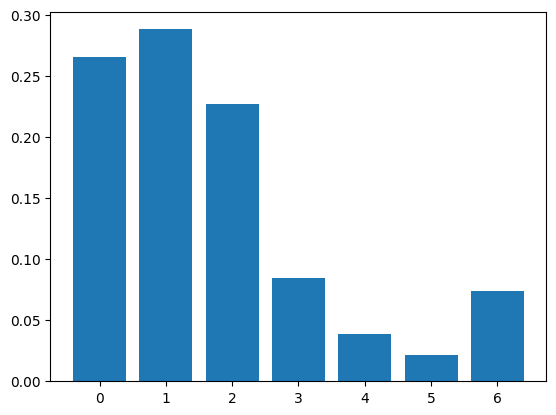

In [37]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

/tmp/ipykernel_19285/1837363767.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_19285/1837363767.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


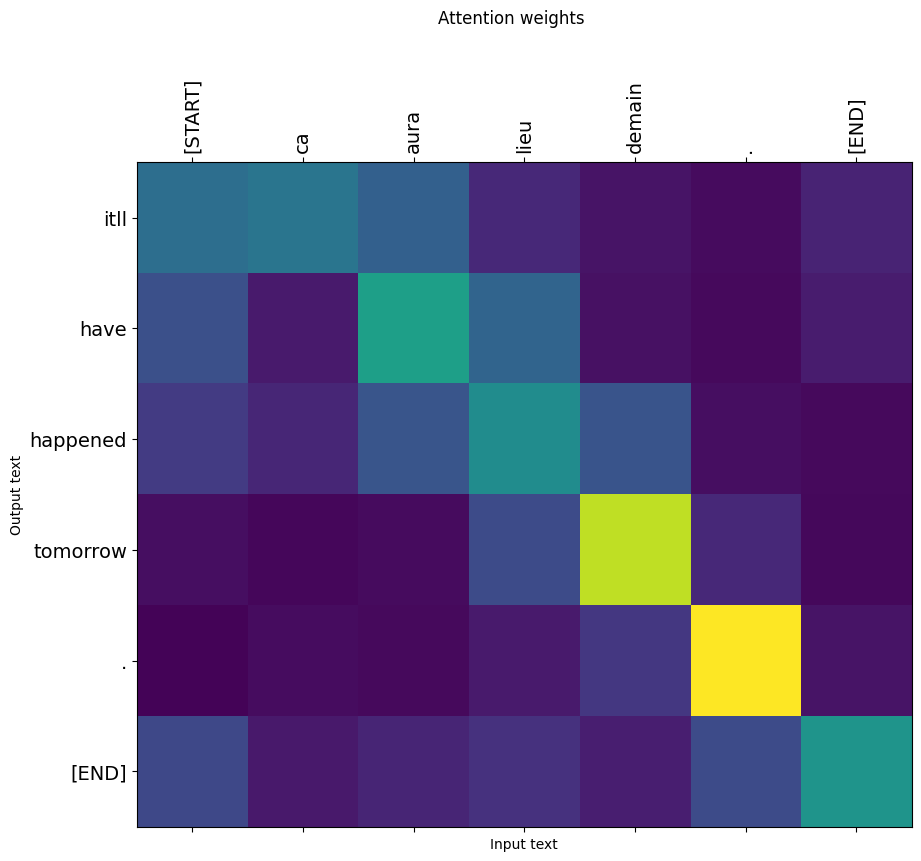

In [46]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])
#La somme horizontale = 1

/tmp/ipykernel_19285/1837363767.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_19285/1837363767.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


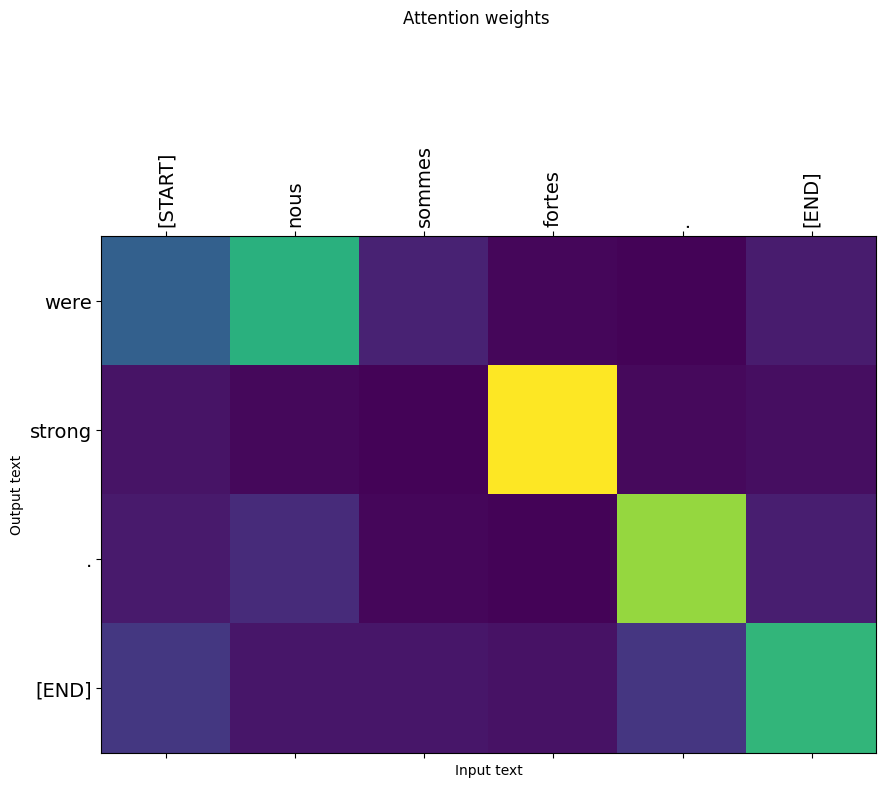

In [47]:
i=1
plot_attention(result['attention'][i], input_text[i], result['text'][i])

In [275]:
print(targ[70202], inp[70202])

You may stay here with me. Il se peut que tu restes ici avec moi.


In [290]:
%%time
three_input_text = tf.constant([
    "Tu n'as pas l'air si occupé.",
    'ils les attendent?',
    "Je viens juste de lire ce livre.",
    "Il se peut que tu restes ici avec moi.",
    'soit prêt.',
])
print(three_input_text)

result = reloaded.tf_translate(three_input_text)

for tr in result['text']:
    print(tr.numpy().decode())

print()

tf.Tensor(
[b"Tu n'as pas l'air si occup\xc3\xa9." b'ils les attendent?'
 b'Je viens juste de lire ce livre.'
 b'Il se peut que tu restes ici avec moi.' b'soit pr\xc3\xaat.'], shape=(5,), dtype=string)
you dont seem so busy .
are you waiting for these ?
i have only just read that book .
you may continue to stay here with me .
its ready .

CPU times: user 3.92 s, sys: 1.64 s, total: 5.55 s
Wall time: 507 ms


In [291]:
result['text']

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'you dont seem so busy .', b'are you waiting for these ?',
       b'i have only just read that book .',
       b'you may continue to stay here with me .', b'its ready .'],
      dtype=object)>

/tmp/ipykernel_19285/1837363767.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_19285/1837363767.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


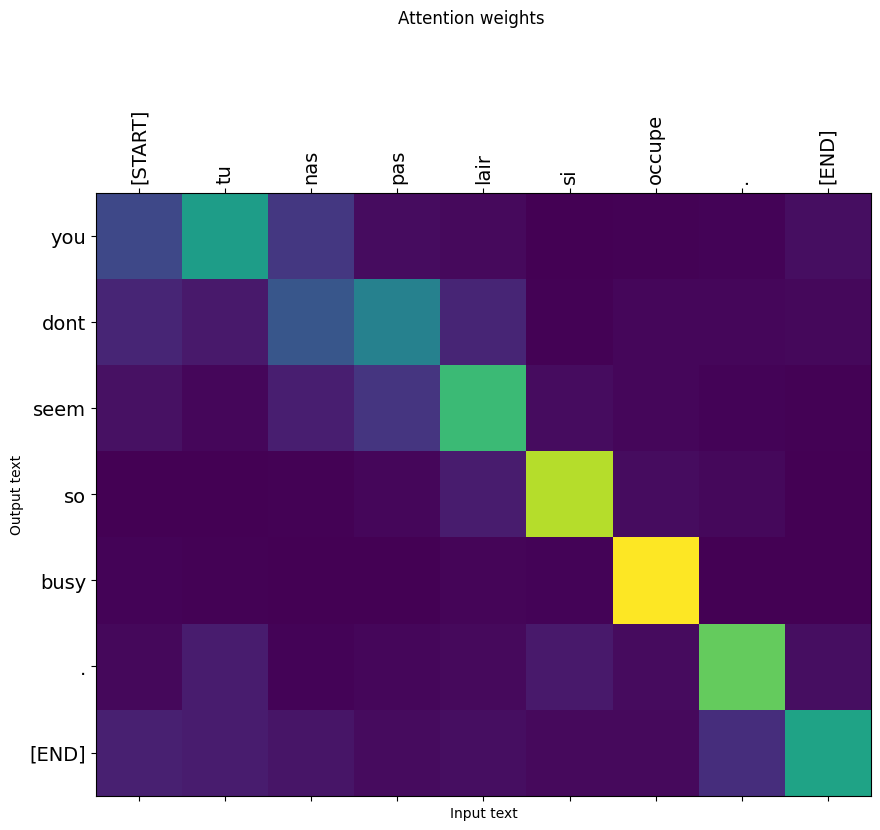

In [292]:
i = 0
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmp/ipykernel_19285/1837363767.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_19285/1837363767.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


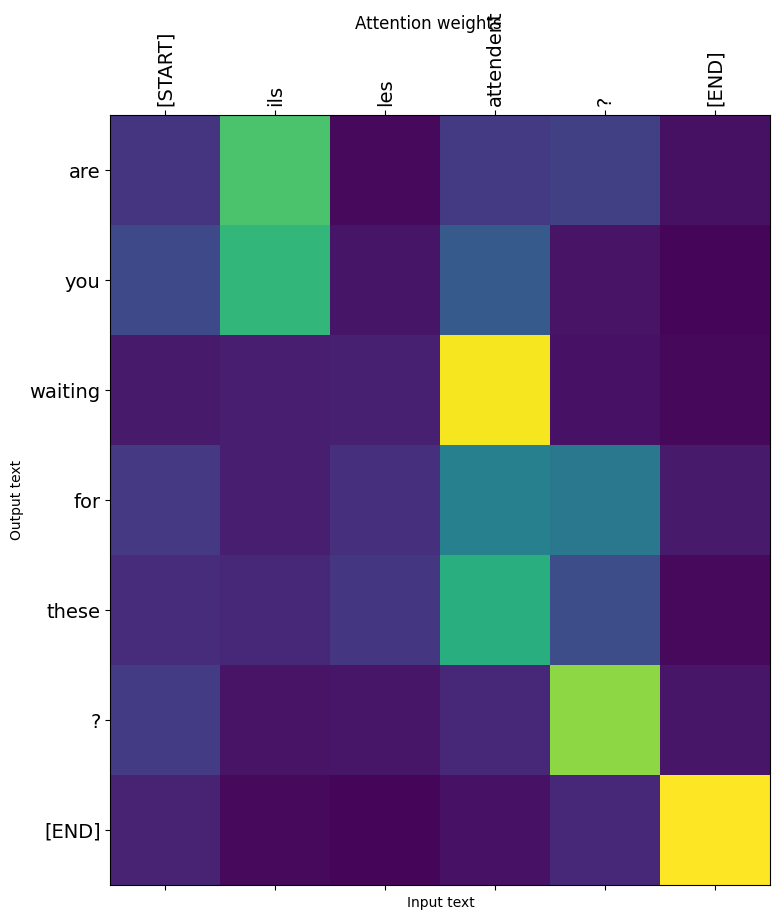

In [293]:
i = 1
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmp/ipykernel_19285/1837363767.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_19285/1837363767.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


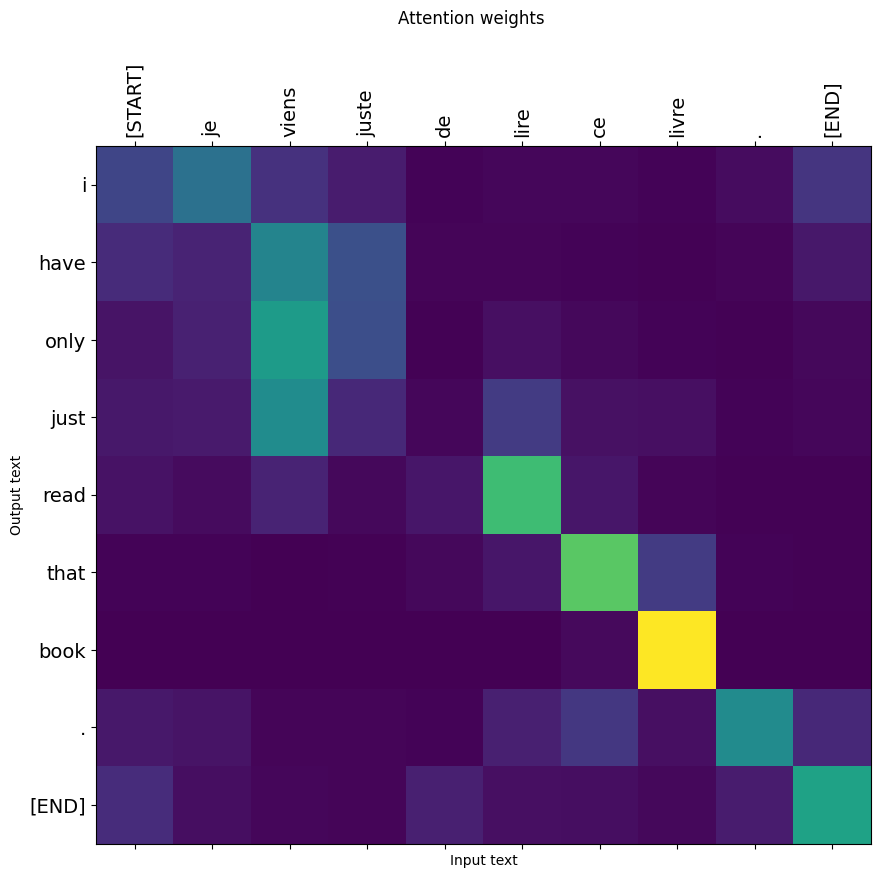

In [294]:
i = 2
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmp/ipykernel_19285/1837363767.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_19285/1837363767.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


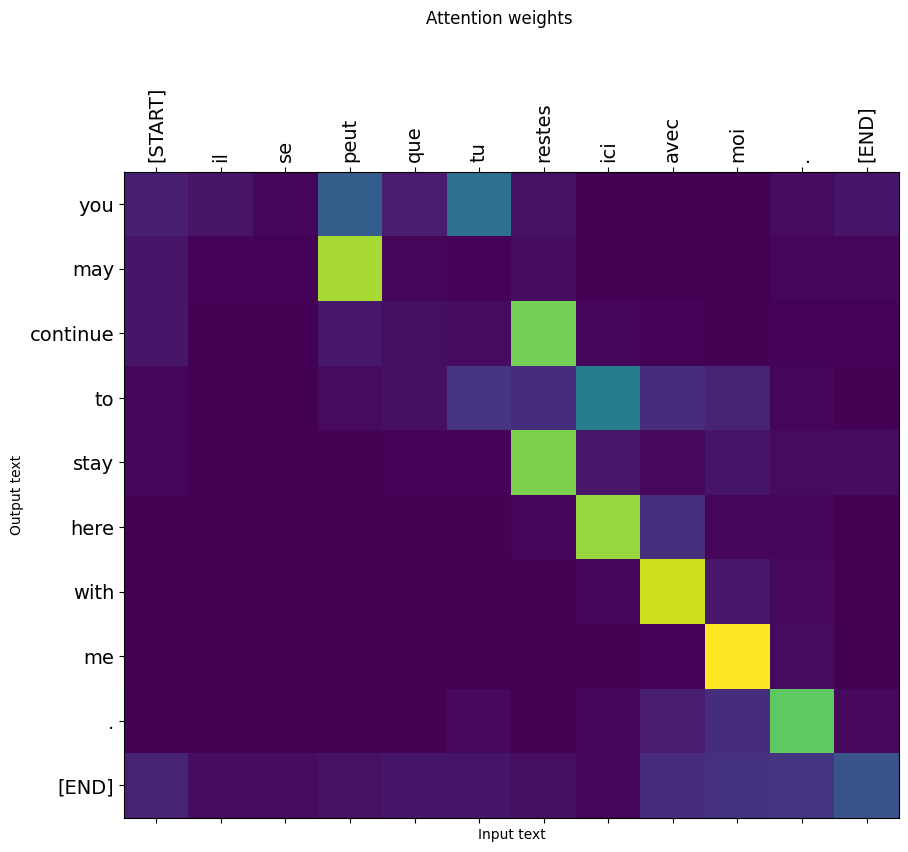

In [295]:
i = 3
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

/tmp/ipykernel_19285/1837363767.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_19285/1837363767.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


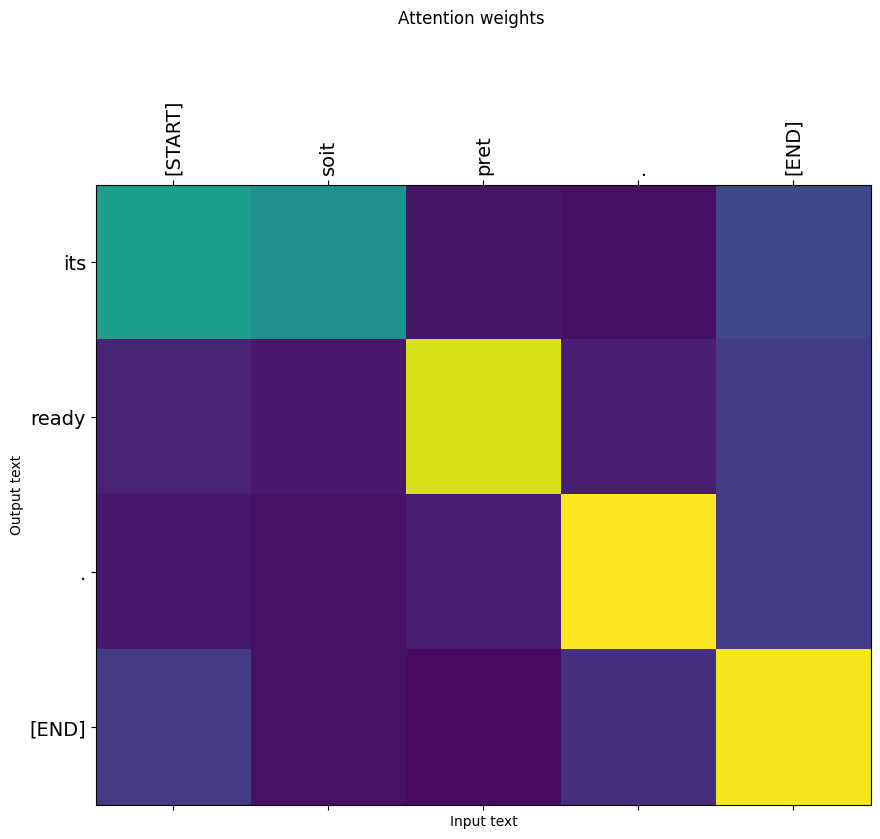

In [296]:
i = 4
plot_attention(result['attention'][i], three_input_text[i], result['text'][i])

In [298]:
long_input_text = tf.constant([inp[-1]])

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(targ[-1])))

Expected output:
 It may be impossible to get a completely error-free corpus due to the
nature of this kind of collaborative effort. However, if we encourage
members to contribute sentences in their own languages rather than
experiment in languages they are learning, we might be able to
minimize errors.


/tmp/ipykernel_19285/1837363767.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_19285/1837363767.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


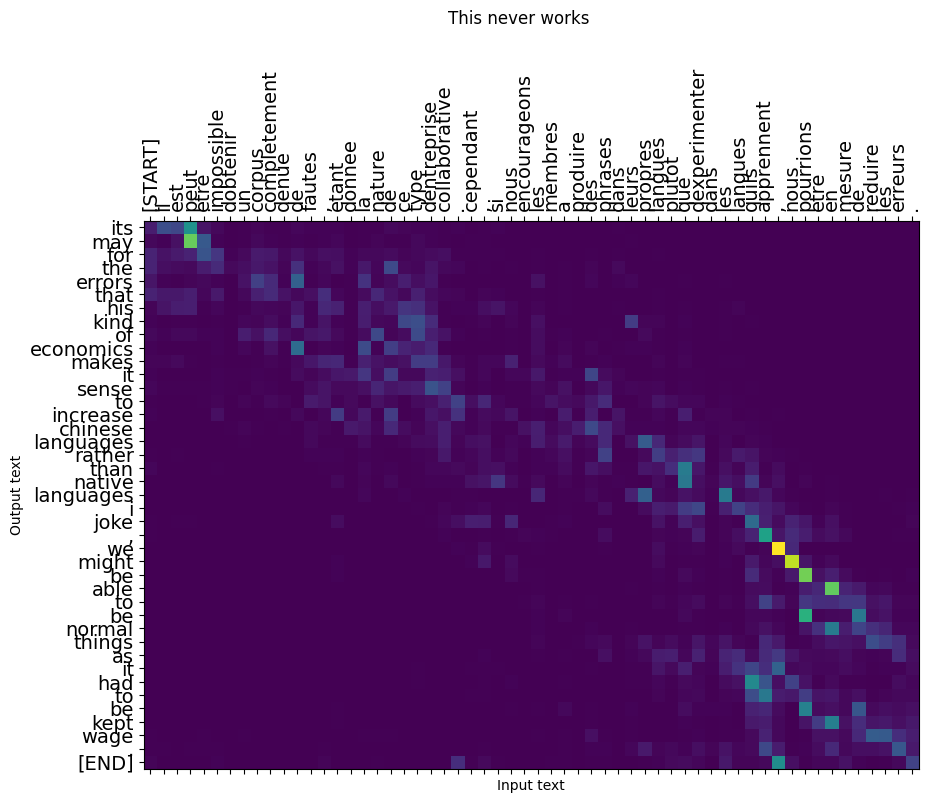

In [67]:
result = reloaded.tf_translate(long_input_text)

i = 0
plot_attention(result['attention'][i], long_input_text[i], result['text'][i])
_ = plt.suptitle('This never works')

In [310]:
def compute_bleuScore(input_texts, target_texts, model):
    
    d
    pd.set_option('max_colwidth', 800)
    
    input_texts =  tf.constant(input_texts)

    trgs = []
    pred_trgs = []
    bleuScore = []
    
    for inp,targ in zip(input_texts,target_texts): 
        
        targ = targ.replace("'", "").replace(".", " .").replace(",", " ,").replace("!", " !").replace("?", " ?")
        targ = targ.lower().split()
        
        model_output = model.tf_translate(input_text = [inp]) 
        pred_trg = model_output['text'][0].numpy().decode()
        
        pred_trgs.append(pred_trg)
        trgs.append([targ])

        bS = sentence_bleu([targ] ,pred_trg.split(),weights=(1, 0, 0, 0))
        bleuScore.append(bS)   
        
    df['Prediction'] = pred_trgs
    df['BLEU score'] = bleuScore
        
    return trgs,pred_trgs,bleuScore,df

In [314]:
from random import sample

input_texts = [
    "Tu n'as pas l'air si occupé.",
    'ils les attendent?',
    "Je viens juste de lire ce livre.",
    "Il se peut que tu restes ici avec moi.",
    'soit prêt.',
]

target_texts = [
    "You don't look so busy.",
    'Are they waiting for them?',
    "I have just read this book.",
    "You may stay here with me.",
    'Be ready.',
]

"""
indx = sample(range(len(inp)),30)
input_texts = [inp[i] for i in indx ]
target_texts = [targ[i] for i in indx ]
"""

trgs,pred_trgs,bleuScore,df = compute_bleuScore(input_texts, target_texts,reloaded)

df

/home/tarek/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


,Source,Target,Prediction,BLEU score
0,Tu n'as pas l'air si occupé.,You don't look so busy.,you dont look so busy .,1.000000
1,ils les attendent?,Are they waiting for them?,are they waiting for them ?,1.000000
2,Je viens juste de lire ce livre.,I have just read this book.,i just have just read this book .,0.875000
3,Il se peut que tu restes ici avec moi.,You may stay here with me.,youd come this way for me .,0.285714
4,soit prêt.,Be ready.,its ready .,0.666667


In [315]:
three_input_text = tf.constant([
    "Tu n'as pas l'air si occupé.",
    'ils les attendent?',
    "Je viens juste de lire ce livre.",
    "Il se peut que tu restes ici avec moi.",
    'soit prêt.',
])

In [313]:
reference = [['its', 'time', '.']]
candidate = ['its', 'time', '.']
score = sentence_bleu(reference, candidate)
print(score)

1.2213386697554703e-77


/home/tarek/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
